In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
import os
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from subprocess import run, PIPE
import sys
 
import dask # Distributed data libary
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
import xarray as xr # Libary to work with labeled n-dimensional data and dask
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
# Set some user specific variables
scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_tmp_dir = TemporaryDirectory(dir=scratch_dir, prefix='threshold')
cluster = SLURMCluster(memory='500GiB',
                       cores=72,
                       project='mh0731',
                       walltime='0:45:00',
                       queue='gpu',
                       name='threshold',
                       scheduler_options={'dashboard_address': ':12435'},
                       local_directory=dask_tmp_dir.name,
                       job_extra=[f'-J threshold', 
                                  f'-D {dask_tmp_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')
cluster.scale(jobs=1) # requests whole nodes
dask_client = Client(cluster)
dask_client.wait_for_workers(9) # gpu-partition has 9 workers per node

In [4]:
data_path = Path('/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/Daily')
glob_pattern_2d = 'pr_*[0-9].nc'
 
# Collect all file names with pathlib's rglob and list compressions 
# dont take first ten days, they are spin-up
file_names = sorted([str(f) for f in data_path.rglob(f'{glob_pattern_2d}')])[10:] #[1:]

In [5]:
file_names

['/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/Daily/pr_20200130.nc',
 '/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/Daily/pr_20200131.nc',
 '/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/Daily/pr_20200201.nc',
 '/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/Daily/pr_20200202.nc',
 '/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/Daily/pr_20200203.nc',
 '/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/Daily/pr_20200204.nc',
 '/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/Daily/pr_20200205.nc',
 '/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/Daily/pr_20200206.nc',
 '/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/Daily/pr_20200207.nc',
 '/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/Daily/pr_20200208.nc',
 '/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/Daily/pr_20200209.nc',
 '/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/Daily/pr_20200210.nc',
 '/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/Daily/pr_20200211.nc',
 '/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/D

Radar data is in mm/hour and model data in kg/m2s. Conversion factor to get from mm/hour to kg/m2s is 1/3600.

In [36]:
# opening all consecutive data does not work well later with the numpy-arrays
# ds = xr.open_mfdataset(file_names, combine='by_coords', parallel=True) # doesnt want to work, maybe too much although in dask
# ds

rain_threshold_in_mm = 5
rain_threshold       = rain_threshold_in_mm / 3600

@dask.delayed
def get_convective_rain(file):
    rain          = np.asarray(xr.open_dataset(file)['pr'])
    assert rain.shape[1] > rain.shape[0] # second dimension are the myriad of cells, not time
    conv_mask     =  rain > rain_threshold
    
    # everython per time step
    n_cells_per_time = rain.shape[1]
    conv_area_fraction = conv_mask.sum(axis=1) / n_cells_per_time
    avg_conv_rain = np.where(conv_mask, rain, 0.).mean(axis=1)
    
    # everything for the whole file (time and space)
    n_rainy_cells = (rain > 0.).sum() 
    n_conv_cells  = conv_mask.sum()
    conv_rain_pixels    = rain[conv_mask] # boolean indexing of 2d-numpy-array returns just 1d-vector
    conv_to_strat_ratio = n_conv_cells / n_rainy_cells
    
    return (avg_conv_rain , conv_area_fraction)

rain_futures = []
for file in file_names:
    rain_futures.append(get_convective_rain(file))

Bring data into distributed memory via persist()

In [37]:
jobs = dask.persist(rain_futures)
progress(jobs, notebook=False)

Gather data into single memory with compute(). Here this acts on data which already was brought into distributed memory via persist(), thus it should be fast.

In [38]:
tuples = dask.compute(*rain_futures)

In [39]:
mean_conv_rain, caf = zip(*tuples)

In [40]:
mean_conv_rain     = np.concatenate(mean_conv_rain) * 3600
conv_area_fraction = np.concatenate(caf)

In [41]:
#print(f'{rain_threshold} should be smaller than {conv_rain.min()}')
#print(f'On average {np.asarray(conv_percentage).mean()*100}% of rainy cells are of convective nature, given a rain threshold of {rain_threshold*3600} mm/hour.')

#ds = xr.open_dataset(file_names[0])
#ds_out = xr.DataArray(conv_rain, name=ds['pr'].name, attrs={**ds['pr'].attrs,**ds.attrs})
#ds_out.to_netcdf('/work/mh0731/m300414/DyWinter_b9/Tropics_20to20/conv_rain_8mmhour.nc')

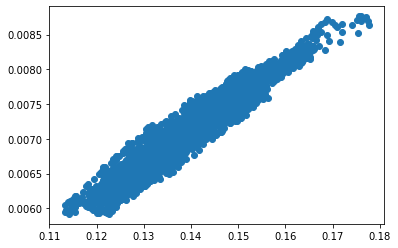

In [42]:
plt.scatter(mean_conv_rain, conv_area_fraction)